# Personlacion de Campaña de Marketing Segmentación de Clientes

En esta tarea, el objetivo es aplicar **Machine Learning** para realizar una segmentación precisa de los **10,000 clientes** previamente seleccionados a través del  algoritmo de recomendación. El enfoque que utilizaremos es el algoritmo **K-Nearest Neighbors (KNN)**, el cual nos permitirá agrupar a los clientes en segmentos bien definidos, basándonos en características demográficas y de comportamiento proporcionadas por el equipo de marketing.

### Variables para la Segmentación

Para la segmentación, se utilizarán las siguientes características clave:

- Edad
- Sexo
- Nivel de ingresos
- Comportamiento y preferencias de compra

### Objetivo de la Segmentación

El objetivo de este análisis es generar **grupos de clientes** que compartan características similares, de modo que el equipo de marketing, liderado por **Erin**, pueda personalizar las creatividades y los mensajes de la campaña de e-mail de manera más efectiva. Al segmentar estos clientes, se espera maximizar la relevancia de las comunicaciones y aumentar las tasas de conversión.

En las próximas secciones se detallará el proceso de implementación del modelo KNN, así como los resultados obtenidos en la generación de estos grupos.




In [1]:
import numpy as np 
import pandas as pd
pd.options.display.float_format = '{:,.3f}'.format
pd.set_option('display.max_columns', 100)
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import RobustScaler,OneHotEncoder
from sklearn.cluster import KMeans

In [2]:
# Leer dataframe con los datos de los 10000 clientes.

df_seleccionados = pd.read_parquet(r'C:\Users\Usuario\Desktop\Nuclio\TFM_Nuclio\easy_money_project\Tarea_3_Recomendación\df_seleccionados.parquet')

El dataset df_seleccionados es el resultado de la Tarea 3 Recomendación. Contiene el pk_cid de los 10.000 clientes a los cuales se les enviarán un email, la recomendación, precio del producto a recomendar , el cluster al que pertence y probabilidad de la compra. Partiremos de este dataset para construir el dataset de la segmentación para la personalización.

In [3]:
df_seleccionados

,pk_cid,recomendacion,prob_compra,precio,beneficio,cluster
226680,1119834,[credit_card],0.987,60,59.212,4
226681,88904,[credit_card],0.987,60,59.191,4
226682,1136278,[credit_card],0.985,60,59.100,4
226686,1119669,[credit_card],0.985,60,59.095,4
226685,1109597,[credit_card],0.985,60,59.095,4
...,...,...,...,...,...,...
229484,1304214,[emc_account],0.955,10,9.553,4
229483,1393343,[payroll_account],0.955,10,9.553,4
229482,1334243,[debit_card],0.955,10,9.553,4
229480,1376649,[emc_account],0.955,10,9.553,4


In [4]:
df_seleccionados['recomendacion'].value_counts()

recomendacion
[debit_card]            3756
[credit_card]           3281
[payroll_account]       1026
[em_acount]              721
[pension_plan]           402
[long_term_deposit]      402
[emc_account]            303
[payroll]                 49
[securities]              28
[short_term_deposit]      22
[funds]                   10
Name: count, dtype: int64

In [5]:
df_seleccionados.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 226680 to 229479
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   pk_cid         10000 non-null  int64  
 1   recomendacion  10000 non-null  object 
 2   prob_compra    10000 non-null  float32
 3   precio         10000 non-null  int64  
 4   beneficio      10000 non-null  float64
 5   cluster        10000 non-null  int64  
dtypes: float32(1), float64(1), int64(3), object(1)
memory usage: 507.8+ KB


Transformar la columna recomendacion a tipo string y luego category, ya que parece que alguna fila era de tipo lista, asi evitamos futuros problemas.

In [6]:
df_seleccionados['recomendacion'] = df_seleccionados['recomendacion'].astype(str).astype('category')


In [7]:
df_seleccionados.duplicated().sum()

0

In [8]:
# Cargando los datos directamente de s3 de AWS
df_full_cleaned = pd.read_parquet("https://easy-money-project-bucket.s3.eu-west-3.amazonaws.com/df_full_cleaned.parquet")
# sociodemografico
sdg_df_cleaned = pd.read_parquet('https://easy-money-project-bucket.s3.eu-west-3.amazonaws.com/sociodemographic_df_adrian.parquet')


df_full_clean = df_full_cleaned.copy()
# se mergea la edad que faltaba en el df_full_cleaned 
df_full_clean = df_full_clean.merge(sdg_df_cleaned[["pk_cid", "pk_partition", "age"]], on=["pk_cid", "pk_partition"], how="inner")

In [9]:
df_full_clean


,pk_cid,pk_partition,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount,num_products_contracts,p_cuenta_bancaria,cuentas_sum,p_inversion,inversion_sum,p_financiacion,financiacion_sum,profit_cuentas,profit_inversion,profit_financiacion,country_id,gender,mes_partition,mes_nombre_partition,grupo_edad,median_salary,region_code,entry_date,entry_channel,active_customer,segment,categoria_antiguedad,age
0,1375586,2018-01-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,ES,H,1,January,Adultos jóvenes,"87,218.100",Málaga,2018-01-12,Otros,1,02 - PARTICULARES,1-2 años,35
1,1050611,2018-01-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,ES,V,1,January,Jóvenes,"35,548.740",Ciudad Real,2015-08-10,KHE,0,03 - UNIVERSITARIO,Más de 3 años,23
2,1050612,2018-01-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,ES,V,1,January,Jóvenes,"122,179.110",Ciudad Real,2015-08-10,KHE,0,03 - UNIVERSITARIO,Más de 3 años,23
3,1050613,2018-01-28,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,40,0,ES,H,1,January,Jóvenes,"119,775.540",Zaragoza,2015-08-10,KHD,0,03 - UNIVERSITARIO,Más de 3 años,22
4,1050614,2018-01-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,ES,V,1,January,Jóvenes,"101,469.135",Zaragoza,2015-08-10,KHE,1,03 - UNIVERSITARIO,Más de 3 años,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5962919,1166765,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,ES,V,5,May,Jóvenes,"43,912.170",Zaragoza,2016-08-14,KHE,0,03 - UNIVERSITARIO,2-3 años,22
5962920,1166764,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,ES,V,5,May,Jóvenes,"23,334.990","Rioja, La",2016-08-14,KHE,0,03 - UNIVERSITARIO,2-3 años,23
5962921,1166763,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,ES,H,5,May,Adultos,"87,930.930",Zaragoza,2016-08-14,KHE,1,02 - PARTICULARES,2-3 años,47
5962922,1166789,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,ES,H,5,May,Jóvenes,"199,592.820",Zaragoza,2016-08-14,KHE,0,03 - UNIVERSITARIO,2-3 años,22


Obtener el ultimo dato de cada cliente, para combinar con el dataframe de los seleccionados.

In [10]:
# Obtener el índice de la última partición para cada pk_cid
idx = df_full_clean.groupby('pk_cid')['pk_partition'].idxmax()

# Filtrar el DataFrame con las últimas particiones
df_full_clean_last = df_full_clean.loc[idx]

In [11]:
df_full_clean_last

,pk_cid,pk_partition,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount,num_products_contracts,p_cuenta_bancaria,cuentas_sum,p_inversion,inversion_sum,p_financiacion,financiacion_sum,profit_cuentas,profit_inversion,profit_financiacion,country_id,gender,mes_partition,mes_nombre_partition,grupo_edad,median_salary,region_code,entry_date,entry_channel,active_customer,segment,categoria_antiguedad,age
2168122,15891,2018-08-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,ES,H,8,August,Adultos mayores,"117,380.925",Madrid,2018-07-28,KAT,0,02 - PARTICULARES,0-3 meses,59
5523397,16063,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,ES,H,5,May,Adultos mayores,"132,384.450",Madrid,2018-11-19,KAT,0,02 - PARTICULARES,6-9 meses,62
5523396,16203,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,ES,V,5,May,Ancianos,"153,902.880",Barcelona,2018-12-23,KAT,1,01 - TOP,3-6 meses,70
5523395,16502,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,2,1,2,0,0,0,0,20,0,0,ES,H,5,May,Adultos mayores,"132,384.450",Madrid,2018-09-30,KHN,1,02 - PARTICULARES,6-9 meses,58
5523398,17457,2019-05-28,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,3,1,2,1,1,0,0,20,40,0,ES,H,5,May,Adultos,"102,405.750",Madrid,2017-09-16,KAT,1,02 - PARTICULARES,1-2 años,54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5679916,1553685,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,ES,V,5,May,Adultos,"114,633.765",Ciudad Real,2019-05-31,Otros,0,03 - UNIVERSITARIO,0-3 meses,52
5679915,1553686,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,ES,H,5,May,Adultos jóvenes,"85,787.220",Sevilla,2019-05-31,Otros,0,03 - UNIVERSITARIO,0-3 meses,30
5679914,1553687,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,ES,V,5,May,Jóvenes,"143,419.770",Madrid,2019-05-31,Otros,0,03 - UNIVERSITARIO,0-3 meses,21
5679913,1553688,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,ES,H,5,May,Adultos,"114,633.765",Cantabria,2019-05-31,Otros,0,03 - UNIVERSITARIO,0-3 meses,43


In [12]:
df_full_clean_last['pk_cid'].duplicated().sum()

0

In [13]:
# Hacer el left join
df_joined = df_seleccionados.merge(df_full_clean_last, on='pk_cid', how='left')

# Mostrar el resultado
df_joined

,pk_cid,recomendacion,prob_compra,precio,beneficio,cluster,pk_partition,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount,num_products_contracts,p_cuenta_bancaria,cuentas_sum,p_inversion,inversion_sum,p_financiacion,financiacion_sum,profit_cuentas,profit_inversion,profit_financiacion,country_id,gender,mes_partition,mes_nombre_partition,grupo_edad,median_salary,region_code,entry_date,entry_channel,active_customer,segment,categoria_antiguedad,age
0,1119834,['credit_card'],0.987,60,59.212,4,2019-05-28,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,3,1,3,0,0,0,0,30,0,0,ES,V,5,May,Adultos mayores,"198,675.690",Madrid,2016-01-29,KFC,1,01 - TOP,Más de 3 años,63
1,88904,['credit_card'],0.987,60,59.191,4,2019-05-28,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,3,1,3,0,0,0,0,30,0,0,ES,H,5,May,Adultos,"871,801.680",Madrid,2015-08-08,KFA,1,01 - TOP,Más de 3 años,48
2,1136278,['credit_card'],0.985,60,59.100,4,2019-05-28,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,4,1,3,1,1,0,0,30,40,0,ES,V,5,May,Adultos,"95,704.380",Cantabria,2016-06-04,KAT,1,01 - TOP,Más de 3 años,53
3,1119669,['credit_card'],0.985,60,59.095,4,2019-05-28,0,0,0,0,0,0,0,0,1,1,0,1,1,0,1,5,1,4,1,1,0,0,40,40,0,ES,V,5,May,Adultos mayores,"82,723.080",Madrid,2016-01-28,KFC,1,01 - TOP,Más de 3 años,58
4,1109597,['credit_card'],0.985,60,59.095,4,2019-05-28,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,5,1,4,1,1,0,0,40,40,0,ES,V,5,May,Adultos mayores,"413,278.020",Madrid,2015-12-04,KFC,1,01 - TOP,Más de 3 años,59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1304214,['emc_account'],0.955,10,9.553,4,2019-05-28,0,0,0,0,0,0,0,0,1,1,1,0,1,0,1,5,1,4,1,1,0,0,40,40,0,ES,V,5,May,Adultos jóvenes,"62,895.900",Badajoz,2017-09-09,RED,1,02 - PARTICULARES,1-2 años,37
9996,1393343,['payroll_account'],0.955,10,9.553,4,2019-05-28,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,2,1,1,0,0,1,1,10,0,60,ES,V,5,May,Adultos jóvenes,"88,963.110",Badajoz,2018-04-21,RED,1,02 - PARTICULARES,1-2 años,38
9997,1334243,['debit_card'],0.955,10,9.553,4,2019-05-28,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,3,1,2,1,1,0,0,20,40,0,ES,V,5,May,Adultos,"63,117.990",Badajoz,2017-10-16,RED,1,02 - PARTICULARES,1-2 años,41
9998,1376649,['emc_account'],0.955,10,9.553,4,2019-05-28,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,4,1,3,1,1,0,0,30,40,0,ES,V,5,May,Adultos,"69,536.970",Badajoz,2018-01-16,RED,1,02 - PARTICULARES,1-2 años,41


Ya tenemos el dataframe con todos los datos de los 10.000 clientes para la segmentacion 

In [14]:
df_joined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 45 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   pk_cid                  10000 non-null  int64         
 1   recomendacion           10000 non-null  category      
 2   prob_compra             10000 non-null  float32       
 3   precio                  10000 non-null  int64         
 4   beneficio               10000 non-null  float64       
 5   cluster                 10000 non-null  int64         
 6   pk_partition            10000 non-null  datetime64[ns]
 7   short_term_deposit      10000 non-null  int8          
 8   loans                   10000 non-null  int8          
 9   mortgage                10000 non-null  int8          
 10  funds                   10000 non-null  int8          
 11  securities              10000 non-null  int8          
 12  long_term_deposit       10000 non-null  int8   

In [15]:
# Contar el número de filas duplicadas
num_duplicated = df_joined.duplicated().sum()

# Mostrar el número de filas duplicadas
print(f"Número de filas duplicadas: {num_duplicated}")

Número de filas duplicadas: 0


In [16]:
# Contar el número de filas duplicadas
num_null = df_joined.isna().sum().sum()

# Mostrar el número de filas duplicadas
print(f"Número de valores nulos: {num_null}")

Número de valores nulos: 0


Despues de comprobar que el dataset no tiene ni valores nulos ni duplicados, seleccionaremos las variables que utilizaremos para la segmentacion.

## Limpieza de atributos


Los valores de fechas serán eliminados y la variable de categoría "antigüedad" también será eliminada. Sin embargo, esta variable puede ser interesante, por lo que calcularemos una nueva que represente los meses de antigüedad para poder usarla en la segmentación.

In [17]:
# Fecha fija para la comparación
fecha_referencia = pd.to_datetime('2019-05-28')

# Calcular los meses de antigüedad
df_joined['meses_antiguedad'] = ((fecha_referencia - df_joined['entry_date']).dt.days // 30).astype(int)

In [18]:
# Eliminar columnas de fechas
df_joined.drop('pk_partition', axis=1, inplace=True)
df_joined.drop('categoria_antiguedad', axis=1, inplace=True)
df_joined.drop('entry_date', axis=1, inplace=True)

En el DataFrame tenemos los datos de todos los productos. Para realizar esta segmentación, sería suficiente conservar el número de productos contratados y la recomendación. Más adelante, evaluaremos la mejor manera de codificar la variable.

In [19]:
# Eliminar columnas de fechas
df_joined.drop('short_term_deposit', axis=1, inplace=True)
df_joined.drop('loans', axis=1, inplace=True)
df_joined.drop('mortgage', axis=1, inplace=True)
df_joined.drop('funds', axis=1, inplace=True)
df_joined.drop('securities', axis=1, inplace=True)
df_joined.drop('long_term_deposit', axis=1, inplace=True)
df_joined.drop('em_account_pp', axis=1, inplace=True)
df_joined.drop('credit_card', axis=1, inplace=True)
df_joined.drop('payroll', axis=1, inplace=True)
df_joined.drop('pension_plan', axis=1, inplace=True)
df_joined.drop('payroll_account', axis=1, inplace=True)
df_joined.drop('emc_account', axis=1, inplace=True)
df_joined.drop('debit_card', axis=1, inplace=True)
df_joined.drop('em_account_p', axis=1, inplace=True)
df_joined.drop('em_acount', axis=1, inplace=True)
df_joined.drop('p_cuenta_bancaria', axis=1, inplace=True)
df_joined.drop('cuentas_sum', axis=1, inplace=True)
df_joined.drop('p_inversion', axis=1, inplace=True)
df_joined.drop('inversion_sum', axis=1, inplace=True)
df_joined.drop('p_financiacion', axis=1, inplace=True)
df_joined.drop('financiacion_sum', axis=1, inplace=True)
df_joined.drop('profit_cuentas', axis=1, inplace=True)
df_joined.drop('profit_inversion', axis=1, inplace=True)
df_joined.drop('profit_financiacion', axis=1, inplace=True)

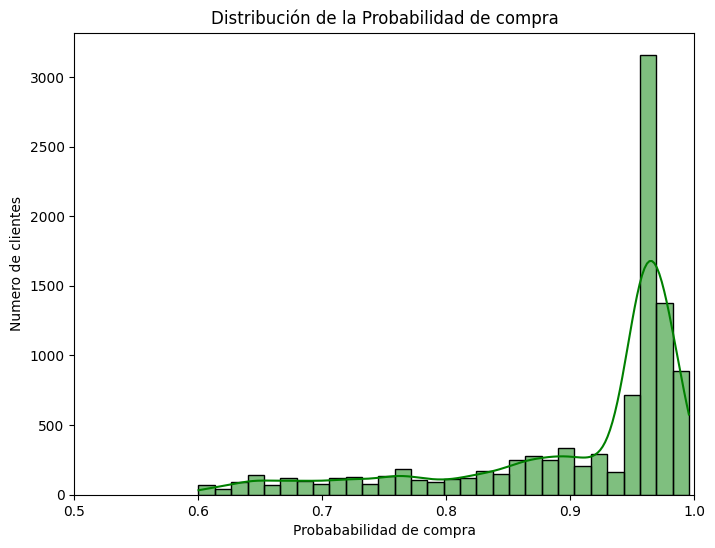

In [20]:
# Supongamos que 'variable_numerica' es el nombre de tu columna numérica que va de 0 a 1
plt.figure(figsize=(8, 6))
sns.histplot(data=df_joined, x='prob_compra', bins=30, color = "green" ,kde=True,stat='count', palette='Spectral')
plt.title('Distribución de la Probabilidad de compra')
plt.xlabel('Probababilidad de compra')
plt.ylabel('Numero de clientes')
plt.xlim(0.5, 1)
plt.xticks(rotation=0)
plt.show()

Añadir la variable prob_compra a la segmentación tiene sentido porque proporciona una estimación clara de la probabilidad de que un cliente realice una compra. Con valores que van de 0.6 a 1, esta variable nos permite identificar distintos niveles de intención de compra. Al segmentar en función de esta probabilidad, podemos personalizar los mensajes de marketing, enfocándonos en aquellos clientes más propensos a realizar una compra y diferenciando estrategias para aquellos con probabilidades más bajas, lo que optimiza la efectividad de la campaña.

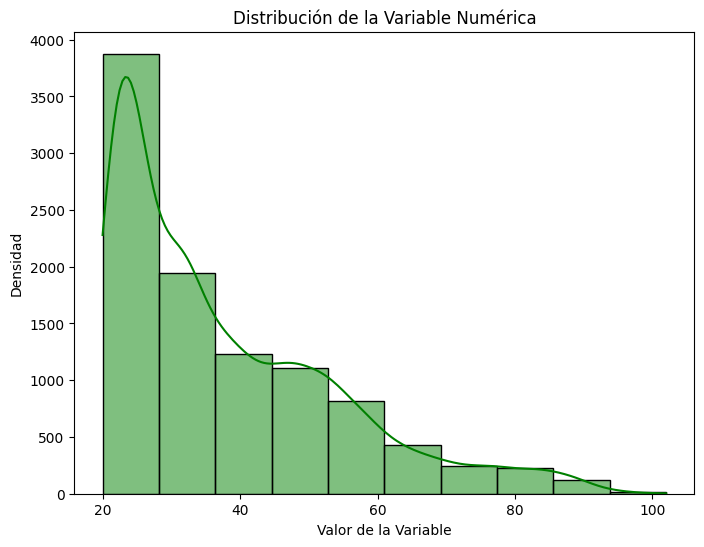

In [21]:
# Supongamos que 'variable_numerica' es el nombre de tu columna numérica que va de 0 a 1
plt.figure(figsize=(8, 6))
sns.histplot(data=df_joined, x='age', bins=10, kde=True, color='green', stat='count', palette='Spectral')
plt.title('Distribución de la Variable Numérica')
plt.xlabel('Valor de la Variable')
plt.ylabel('Densidad')
plt.xticks(rotation=0)
plt.show()

Añadir la variable edad a la segmentación es fundamental porque las necesidades, preferencias y comportamientos de compra suelen variar significativamente en función de la etapa de la vida en la que se encuentra un cliente. La edad influye en muchos aspectos, desde los productos o servicios que podrían interesar hasta la forma en que un cliente prefiere recibir información. Al segmentar por edad, podemos personalizar las campañas para que sean más relevantes y atractivas para cada grupo demográfico, aumentando así la efectividad de la estrategia de marketing.

In [22]:
df_joined.describe()

,pk_cid,prob_compra,precio,beneficio,cluster,num_products_contracts,mes_partition,median_salary,active_customer,age,meses_antiguedad
count,"10,000.000","10,000.000","10,000.000","10,000.000","10,000.000","10,000.000","10,000.000","10,000.000","10,000.000","10,000.000","10,000.000"
mean,"1,235,986.065",0.907,28.997,24.568,2.917,1.661,5.011,"117,541.027",0.545,37.839,26.232
std,"195,216.580",0.097,23.177,18.410,1.692,1.640,0.356,"177,107.252",0.498,16.409,13.543
min,"29,947.000",0.600,10.000,9.553,0.000,0.000,1.000,"8,547.750",0.000,20.000,1.000
25%,"1,120,691.250",0.871,10.000,9.616,2.000,0.000,5.000,"70,609.905",0.000,24.000,15.000
50%,"1,245,472.000",0.956,10.000,9.823,3.000,1.000,5.000,"92,038.050",1.000,33.000,26.000
75%,"1,377,481.000",0.967,60.000,43.123,4.000,2.000,5.000,"132,271.560",1.000,48.000,38.000
max,"1,547,741.000",0.996,60.000,59.212,5.000,9.000,12.000,"11,139,895.560",1.000,102.000,53.000


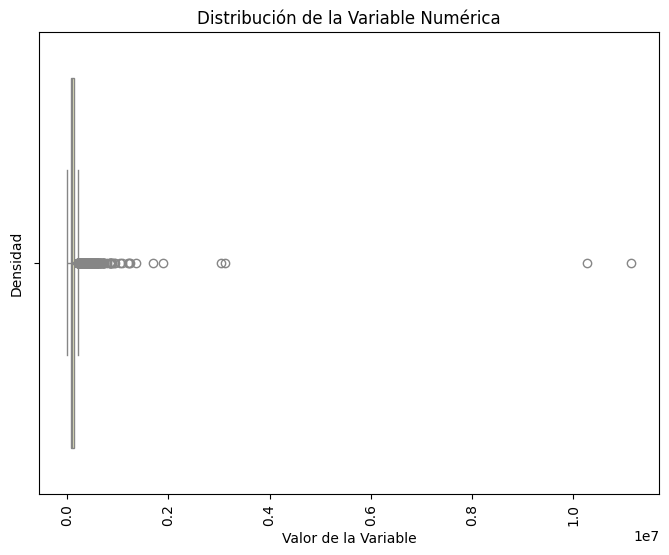

In [23]:
# Supongamos que 'variable_numerica' es el nombre de tu columna numérica que va de 0 a 1
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_joined, x='median_salary', color='green',  palette='Spectral')
plt.title('Distribución de la Variable Numérica')
plt.xlabel('Valor de la Variable')
plt.ylabel('Densidad')
plt.xticks(rotation=90)
plt.show()

Vamos a tratar los outliers en la variable median_salary porque los valores extremadamente altos pueden distorsionar el rendimiento del modelo. Estos outliers pueden sesgar la segmentación, haciendo que el modelo se enfoque en patrones que no son representativos del comportamiento general de los clientes. Al limitar estos valores, reducimos su impacto negativo y mejoramos la capacidad del modelo para identificar grupos más consistentes y útiles para la campaña de marketing. 

In [25]:
# Calcular los percentiles 90% y 95%
percentile_90 = df_joined['median_salary'].quantile(0.90)
percentile_95 = df_joined['median_salary'].quantile(0.95)

# Imprimir los resultados
print(f"Percentil 90: {percentile_90}")
print(f"Percentil 95: {percentile_95}")

Percentil 90: 193746.768
Percentil 95: 249174.44999999995



Limitar el valor de median_salary en el percentil 95% es una técnica común para tratar outliers sin eliminar datos por completo. Al limitar el salario en el percentil 95%, mantenemos la mayoría de los datos representativos y reducimos la influencia de valores atípicos. Esta técnica permite que el modelo se concentre en la distribución típica de los salarios y mejora la capacidad de generalización en la segmentación de clientes.

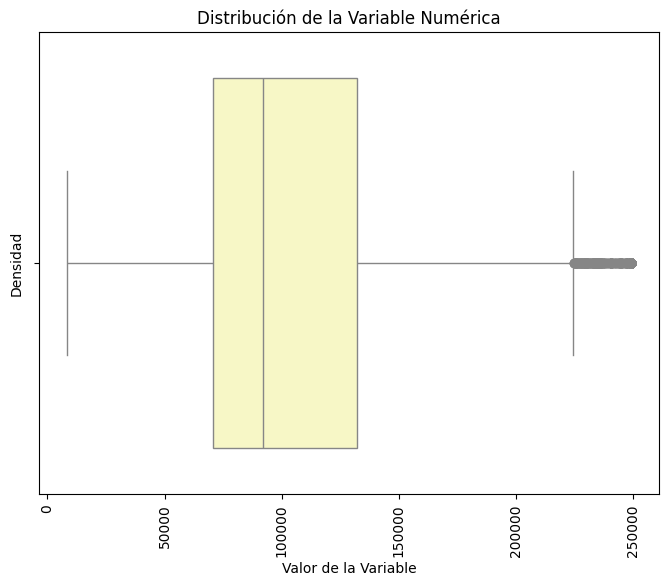

In [26]:
# Limitar el median_salary al percentil 95
df_joined['median_salary'] = df_joined['median_salary'].apply(lambda x: min(x, percentile_95))

# Supongamos que 'variable_numerica' es el nombre de tu columna numérica que va de 0 a 1
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_joined, x='median_salary', color='green',  palette='Spectral')
plt.title('Distribución de la Variable Numérica')
plt.xlabel('Valor de la Variable')
plt.ylabel('Densidad')
plt.xticks(rotation=90)
plt.show()

In [43]:
df_joined

,pk_cid,recomendacion,prob_compra,precio,beneficio,cluster,num_products_contracts,country_id,gender,mes_partition,mes_nombre_partition,grupo_edad,median_salary,region_code,entry_channel,active_customer,segment,age,meses_antiguedad
0,1119834,['credit_card'],0.987,60,59.212,4,3,ES,V,5,May,Adultos mayores,"198,675.690",Madrid,KFC,1,01 - TOP,63,40
1,88904,['credit_card'],0.987,60,59.191,4,3,ES,H,5,May,Adultos,"871,801.680",Madrid,KFA,1,01 - TOP,48,46
2,1136278,['credit_card'],0.985,60,59.100,4,4,ES,V,5,May,Adultos,"95,704.380",Cantabria,KAT,1,01 - TOP,53,36
3,1119669,['credit_card'],0.985,60,59.095,4,5,ES,V,5,May,Adultos mayores,"82,723.080",Madrid,KFC,1,01 - TOP,58,40
4,1109597,['credit_card'],0.985,60,59.095,4,5,ES,V,5,May,Adultos mayores,"413,278.020",Madrid,KFC,1,01 - TOP,59,42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1304214,['emc_account'],0.955,10,9.553,4,5,ES,V,5,May,Adultos jóvenes,"62,895.900",Badajoz,RED,1,02 - PARTICULARES,37,20
9996,1393343,['payroll_account'],0.955,10,9.553,4,2,ES,V,5,May,Adultos jóvenes,"88,963.110",Badajoz,RED,1,02 - PARTICULARES,38,13
9997,1334243,['debit_card'],0.955,10,9.553,4,3,ES,V,5,May,Adultos,"63,117.990",Badajoz,RED,1,02 - PARTICULARES,41,19
9998,1376649,['emc_account'],0.955,10,9.553,4,4,ES,V,5,May,Adultos,"69,536.970",Badajoz,RED,1,02 - PARTICULARES,41,16


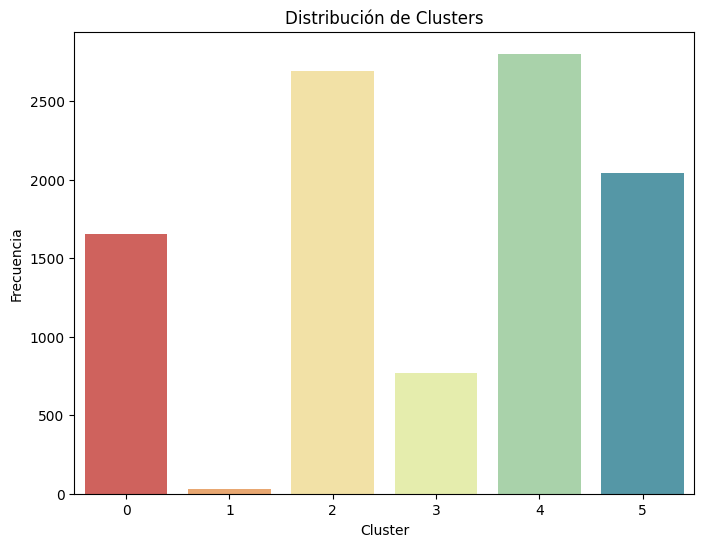

In [28]:
# Creamos el gráfico de barras utilizando seaborn
plt.figure(figsize=(8, 6))
sns.countplot(data=df_joined, x='cluster', palette='Spectral')
plt.title('Distribución de Clusters')
plt.xlabel('Cluster')
plt.ylabel('Frecuencia')
plt.xticks(rotation=0)
plt.show()

In [35]:
# Contar cuántas veces aparece cada valor en la columna 'country_id'
country_counts = df_joined['country_id'].value_counts()

# Mostrar los resultados
print(country_counts)

country_id
ES    9987
GB       3
CH       2
RO       1
CI       1
FR       1
CL       1
CA       1
US       1
MX       1
PE       1
Name: count, dtype: int64
